##GCAI Model Training:
*By Edwin Tembo*

*This is loosely based on Khazuito00.*

In [ ]:
%pip install -q mlflow pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.1/575.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
import csv
from pyngrok import ngrok
import mlflow
from mlflow.models import infer_signature
import numpy as np
import tensorflow as tf
import pandas as pd
from datetime import datetime
from mlflow.models import ModelSignature
from mlflow.types.schema import Schema, ColSpec, TensorSpec

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from pathlib import Path
from google.colab import userdata

RANDOM_SEED = 1000
TRAIN       = False

In [ ]:
mlflow_path       ='/content/drive/MyDrive/HES/ASSIGNMENTS/GCAI/mlflow'
!mkdir -p $mlflow_path
%env mlflow_path = '/content/drive/MyDrive/HES/ASSIGNMENTS/GCAI/mlflow'

env: mlflow_path='/content/drive/MyDrive/HES/ASSIGNMENTS/GCAI/mlflow'


In [ ]:
PROJECT_NAME = "TFMODELS"

mlflow_project_path = Path(f"{mlflow_path}/{PROJECT_NAME}")
mlflow_project_path.mkdir(exist_ok=True)

!touch /{mlflow_path}/{PROJECT_NAME}/output.log
!nohup mlflow server --backend-store-uri {mlflow_path}/{PROJECT_NAME}/content/mlruns --default-artifact-root /{mlflow_path}/{PROJECT_NAME}/content/mlruns --host 0.0.0.0 --port 5000 > {mlflow_path}/{PROJECT_NAME}/output.log 2>&1 &
!pgrep mlflow
!pip install pyngrok

ngrok_token = userdata.get('ngrok_token')

!ngrok config add-authtoken {ngrok_token}
service = "ngrok"
# Find the PID of the ngrok process
pids = !pgrep {service}

# If ngrok is running, kill it
if pids:
  pid = pids[0]  # Assuming you want to kill the first ngrok process if there are multiple
  !kill -9 {pid}
  print(f"{service} killed")
else:
  print(f"{service} is not running.")

2158
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
ngrok is not running.


In [ ]:
port = "5000"

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

 * ngrok tunnel "https://133c-34-125-80-242.ngrok-free.app" -> "http://127.0.0.1:5000"


In [ ]:
### using local mlflow server
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [ ]:
mlflow.set_experiment("/gesture-classification")

<Experiment: artifact_location='//content/drive/MyDrive/HES/ASSIGNMENTS/GCAI/mlflow/TFMODELS/content/mlruns/398191148141779413', creation_time=1732393654486, experiment_id='398191148141779413', last_update_time=1732393654486, lifecycle_stage='active', name='/gesture-classification', tags={}>

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/hand_gestures/data/keypoint_z.csv', header=None)

<ipython-input-8-e7d68fbf6073>:1: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/hand_gestures/data/keypoint_z.csv', header=None)


In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,142071.0,142071.0,142071.0,142071.000000,142071.000000,142071.000000,142071.000000,142071.000000,142071.000000,142071.000000,...,142071.000000,142071.000000,142071.000000,142071.000000,142071.000000,142071.000000,142071.000000,142071.000000,142071.000000,142071.000000
mean,-1.0,0.0,0.0,-0.016907,-0.119245,-0.022606,-0.240823,-0.018459,-0.312427,-0.011087,...,-0.665481,-0.697067,-0.381718,-0.676542,-0.610506,-0.512868,-0.537914,-0.708689,-0.596745,-0.471460
std,0.0,0.0,0.0,0.195033,0.142415,0.358462,0.286593,0.470815,0.412945,0.545903,...,0.336105,0.343082,0.272843,0.320490,0.325916,0.341625,0.317921,0.350397,0.372960,0.410909
min,-1.0,0.0,0.0,-0.588235,-0.616438,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.0,0.0,0.0,-0.177419,-0.214286,-0.333333,-0.428571,-0.437500,-0.589744,-0.481342,...,-0.855968,-0.906361,-0.550502,-0.892675,-0.810146,-0.726805,-0.728740,-0.960599,-0.853020,-0.743204
50%,-1.0,0.0,0.0,-0.054054,-0.135135,-0.056338,-0.292683,-0.017241,-0.400000,0.000000,...,-0.741724,-0.785495,-0.411144,-0.760165,-0.683354,-0.542270,-0.602098,-0.818098,-0.713588,-0.565710
75%,-1.0,0.0,0.0,0.160000,-0.048780,0.303030,-0.149254,0.406250,-0.153005,0.469136,...,-0.615082,-0.628068,-0.273382,-0.575474,-0.519502,-0.363490,-0.428968,-0.604237,-0.460825,-0.299966
max,-1.0,0.0,0.0,0.550725,0.500000,0.923077,0.833333,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.998994,0.974136,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.dropna(how="any" , inplace=True)

In [ ]:
labels = df[64].unique()

In [ ]:
labels

array(['z_palm_facing_in_pull', 'z_palm_facing_in_pull_left',
       'zoom_out_right', 'zoom_out_left', 'pointer_up_right',
       'pointer_left_right', 'pointer_left_right_is_actually_up_left',
       'pointer_down_right', 'pointer_down_left', 'pointer_goleft_right',
       'pointer_goright_right', 'pointer_goright_left',
       'pointer_goleft_left', 'two_fingers_right', 'two_fingers_left',
       'fist_right', 'fist_left', 'palm_left', 'palm_right', 'zoom_in',
       'zoom_in_left', 'thumbs_up_right', 'thumbs_up_left'], dtype=object)

In [ ]:
df.loc[df[64] == 'pointer_left_right_is_actually_up_left', 64] = 'pointer_up_left'

In [ ]:
df.loc[df[64] == 'pointer_left_right', 64] = 'pointer_up_left'

In [ ]:
df.loc[df[64] == 'zoom_in', 64] = 'zoom_in_right'

In [ ]:
labels = df[64].unique()

In [ ]:
labels

array(['z_palm_facing_in_pull', 'z_palm_facing_in_pull_left',
       'zoom_out_right', 'zoom_out_left', 'pointer_up_right',
       'pointer_up_left', 'pointer_down_right', 'pointer_down_left',
       'pointer_goleft_right', 'pointer_goright_right',
       'pointer_goright_left', 'pointer_goleft_left', 'two_fingers_right',
       'two_fingers_left', 'fist_right', 'fist_left', 'palm_left',
       'palm_right', 'zoom_in_right', 'zoom_in_left', 'thumbs_up_right',
       'thumbs_up_left'], dtype=object)

In [ ]:
NUM_CLASSES = len(labels)

In [ ]:
df[64].value_counts()


,count
64,
pointer_down_right,11301
palm_right,10214
two_fingers_right,9554
fist_right,9118
pointer_goleft_left,6770
fist_left,6551
palm_left,6548
z_palm_facing_in_pull,6522
thumbs_up_left,6479


In [ ]:
optimizer   ='adam'
loss        ='sparse_categorical_crossentropy'
metrics     =['accuracy']
batch_size  = 32000
epochs      = 1000
patience    = 40
early_stopping_metric = 'val_loss'


es_callback = tf.keras.callbacks.EarlyStopping(monitor=early_stopping_metric, patience=patience, verbose=1)

params = {"random_seed"       : RANDOM_SEED,
          "optimizer"         : f"{optimizer}" ,
          "loss_fn"           : f"{loss}" ,
          "patience"          : patience,
          "epochs"            : epochs,
          "batch_size"        : batch_size,
          "optimizer"         : optimizer,
          "resampling_method" : "over",
          "early_stopping_metric" : early_stopping_metric
          }



batch_size

32000

In [ ]:
resampling_method =  params['resampling_method']


if resampling_method is not None:
  if resampling_method == 'over':
    resampling_txt = '_oversampling'
  elif resampling_method == 'under':
    resampling_txt = '_undersampling'
  elif resampling_method == 'both':
    resampling_txt = '_over_under_sample'
  else:
    resampling_txt = ''
else:
  resampling_txt = ''

print(f"Resmapling method : {resampling_method}")

Resmapling method : over


In [ ]:
df[0] = [np.argwhere(labels == x)[0][0] for x in df[64]]

In [ ]:
X_dataset = df.loc[:, 1:63]


In [ ]:
y_dataset = df.loc[:, 0]
y_dataset = y_dataset.astype('int32')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

if resampling_method in  ('over' , 'both'):
  from imblearn.over_sampling import SMOTE, ADASYN
  print('oversampling')
  X_train, y_train = SMOTE().fit_resample(X_train, y_train)


if resampling_method in ('under', 'both'):
  from imblearn.under_sampling import NearMiss
  nm1 = NearMiss(version=1)
  print('undersampling')
  X_train, y_train = nm1.fit_resample(X_train, y_train)



oversampling


In [48]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Input((63, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1400, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(700, activation='relu'),
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [49]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)                  │ (None, 63)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1400)                │          89,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 700)                 │         980,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 60)                  │          42,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 22)                  │           1,342 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113,702 (4.25 MB)

 Trainable params: 1,113,702 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer= params['optimizer'],
    loss     = params['loss_fn'],
    metrics  = metrics
)

In [ ]:
params

{'random_seed': 1000,
 'optimizer': 'adam',
 'loss_fn': 'sparse_categorical_crossentropy',
 'patience': 40,
 'epochs': 1000,
 'batch_size': 32000,
 'resampling_method': 'over',
 'early_stopping_metric': 'val_loss'}

In [ ]:
X_train.to_numpy().shape, y_train.to_numpy().shape
epochs
batch_size
X_test.to_numpy().shape, y_test.to_numpy().shape

((35518, 63), (35518,))

In [ ]:
if TRAIN:
    mlflow.tensorflow.autolog(checkpoint=True, checkpoint_save_best_only=False)

    with mlflow.start_run() as run:
        mlflow.log_params(params)
            # Train the model
        history = model.fit(X_train.to_numpy(),
                            y_train.to_numpy(),
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_test.to_numpy(), y_test.to_numpy()) ,
                            callbacks=[es_callback]
                          )

        # Log metrics
        for epoch in range(len(history.history['loss'])):
            mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
            mlflow.log_metric("acc", history.history['accuracy'][epoch], step=epoch)
            mlflow.log_metric("val_acc", history.history['val_accuracy'][epoch], step=epoch)

        # Log the model
        mlflow.tensorflow.log_model(model, "model")

In [ ]:
experiment = mlflow.get_experiment_by_name("/gesture-classification")

In [ ]:
experiment

<Experiment: artifact_location='//content/drive/MyDrive/HES/ASSIGNMENTS/GCAI/mlflow/TFMODELS/content/mlruns/398191148141779413', creation_time=1732393654486, experiment_id='398191148141779413', last_update_time=1732393654486, lifecycle_stage='active', name='/gesture-classification', tags={}>

In [ ]:
##Best Model
model_uri = '/content/drive/MyDrive/HES/ASSIGNMENTS/GCAI/mlflow/TFMODELS/content/mlruns/398191148141779413/fb93bbb6f41a48829cfc0c8eeb9e811a/artifacts/checkpoints/epoch_3/checkpoint.h5'

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model(model_uri)

In [ ]:
val_loss, val_acc = loaded_model.evaluate(X_test, y_test, batch_size=32000)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step - accuracy: 0.9797 - loss: 0.0834


#Convert to TFLite

In [ ]:
now = datetime.now().strftime("%Y%m%d%H%M%S")
model_name = f'keypoint_classifier_{now}_{batch_size}'
model_dir  = f'/content/drive/MyDrive/HES/ASSIGNMENTS/GCAI/GCAI_best/{model_name}{resampling_txt}'
!mkdir {model_dir}
model_save_path = f'{model_dir}/keypoint_classifier_{now}_{batch_size}.keras'
model_save_path

'/content/drive/MyDrive/HES/ASSIGNMENTS/GCAI/GCAI_best/keypoint_classifier_20241124191842_32000_oversampling/keypoint_classifier_20241124191842_32000.keras'

In [ ]:
loaded_model.save(model_save_path, include_optimizer=False)

In [ ]:

class ConvertToTFLite:
  def __init__(self,
               X_test,
               y_test,
               tf_model=loaded_model,
               model_path=model_save_path,
               tflite_save_path = None):
    self.X_test     = X_test
    self.y_test     = y_test
    self.y_pred     = None
    self.tf_model   = tf_model
    self.model_path = model_path
    self.accuracy   = None
    self.confusion_matrix      = None
    self.classification_report = None
    if tflite_save_path is None:
        self.tflite_save_path      = f'{model_save_path.replace(".keras", "").replace(".h5", "")}.tflite'
    else :
        self.tflite_save_path = tflite_save_path
  def convert(self ):
      converter = tf.lite.TFLiteConverter.from_keras_model(self.tf_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      tflite_quantized_model = converter.convert()
      open(self.tflite_save_path, 'wb').write(tflite_quantized_model)

  def eval(self):
      interpreter = tf.lite.Interpreter(model_path=self.tflite_save_path)
      interpreter.allocate_tensors()

      input_details = interpreter.get_input_details()
      output_details = interpreter.get_output_details()

      interpreter.resize_tensor_input(input_details[0]['index'],[self.X_test.shape[0], self.X_test.shape[1]])
      interpreter.allocate_tensors()
      interpreter.set_tensor(input_details[0]['index'], self.X_test.to_numpy(dtype=np.float32))

      interpreter.invoke()
      tflite_results = interpreter.get_tensor(output_details[0]['index'])
      print("\n Eval Results \n")
      print(np.squeeze(tflite_results))
      self.y_pred = np.argmax(np.squeeze(tflite_results), axis=1)

  def get_eval_results(self):
      y_true = self.y_test
      self.accuracy = accuracy_score(y_true, self.y_pred, normalize= True)
      self.confusion_matrix = confusion_matrix(y_test, self.y_pred, labels=sorted(list(set(y_true))))
      self.classification_report = classification_report(y_true, self.y_pred, target_names=None)


In [ ]:
tl_model = ConvertToTFLite(X_test, y_test, loaded_model, model_save_path)

In [ ]:
tl_model.convert()

Saved artifact at '/tmp/tmpkvxfutt_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 63), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 22), dtype=tf.float32, name=None)
Captures:
  139161632197968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139161632703232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139161630890592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139161630890064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139161630896224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139161630897104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139161620546656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139161620546128: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
tl_model.eval()
tl_model.get_eval_results()
cm = tl_model.confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = sorted(list(set(y_test))))



 Eval Results 

[[8.3147088e-06 9.3891369e-03 3.6112076e-05 ... 2.3011362e-08
  3.8004990e-09 2.2425104e-13]
 [1.2616155e-06 2.2817794e-06 2.0100199e-06 ... 2.6755252e-08
  5.6708327e-08 8.5703444e-11]
 [4.6188525e-10 5.1160742e-07 1.1407456e-10 ... 2.1782162e-13
  9.6792105e-04 9.9902582e-01]
 ...
 [9.8405021e-01 9.7048292e-03 5.1137507e-05 ... 2.3146786e-10
  5.1246567e-09 6.7053025e-13]
 [4.1279313e-06 1.7317973e-09 9.2458635e-07 ... 4.0241395e-12
  7.7578524e-04 4.4383702e-04]
 [8.0884178e-08 1.3618996e-10 2.1563892e-14 ... 9.9997151e-01
  1.1699173e-11 5.3823150e-08]]


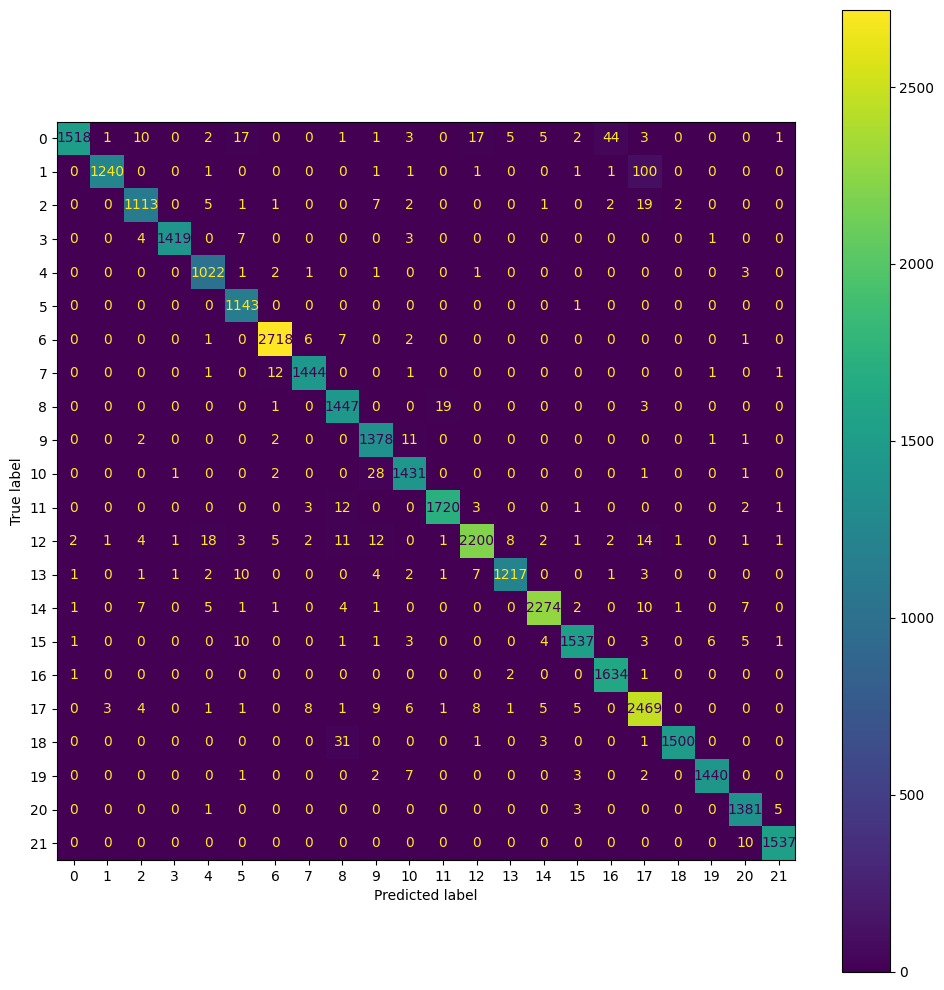

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["figure.autolayout"] = True
disp.plot()
plt.show()

In [ ]:
print(tl_model.classification_report)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1630
           1       1.00      0.92      0.96      1346
           2       0.97      0.97      0.97      1153
           3       1.00      0.99      0.99      1434
           4       0.97      0.99      0.98      1031
           5       0.96      1.00      0.98      1144
           6       0.99      0.99      0.99      2735
           7       0.99      0.99      0.99      1460
           8       0.96      0.98      0.97      1470
           9       0.95      0.99      0.97      1395
          10       0.97      0.98      0.97      1464
          11       0.99      0.99      0.99      1742
          12       0.98      0.96      0.97      2290
          13       0.99      0.97      0.98      1250
          14       0.99      0.98      0.99      2314
          15       0.99      0.98      0.98      1572
          16       0.97      1.00      0.98      1638
          17       0.94    

#ORIGINAL UNDERSAMPLED MODEL

In [ ]:
##Model SubGraph and Trainable
path = '/content/keypoint_classifier_20241027010314_32000_undersampled.tflite'

In [ ]:
tl_model = ConvertToTFLite(X_test, y_test, loaded_model,tflite_save_path=path, model_path=None )

In [ ]:
tl_model.eval()
tl_model.get_eval_results()
cm = tl_model.confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels = sorted(list(set(y_test))))


 Eval Results 

[[3.2954351e-05 2.6356759e-02 1.0794286e-04 ... 3.6373194e-06
  2.3016511e-09 3.3612777e-13]
 [7.4704366e-07 1.4746928e-04 8.8385168e-06 ... 2.3376360e-06
  1.9814284e-08 7.0205469e-10]
 [2.6624367e-10 1.5957660e-07 2.2622103e-07 ... 1.1767366e-08
  1.3292499e-03 9.9861884e-01]
 ...
 [9.9113727e-01 1.2251190e-03 4.4004479e-05 ... 3.2878145e-11
  1.7041796e-08 1.7038019e-13]
 [2.3938057e-05 4.9124839e-08 3.4144272e-05 ... 1.3402104e-10
  1.0860983e-03 4.0433980e-03]
 [7.6761388e-09 3.2304180e-07 4.4816806e-13 ... 9.9992847e-01
  1.1636836e-09 8.0281282e-08]]


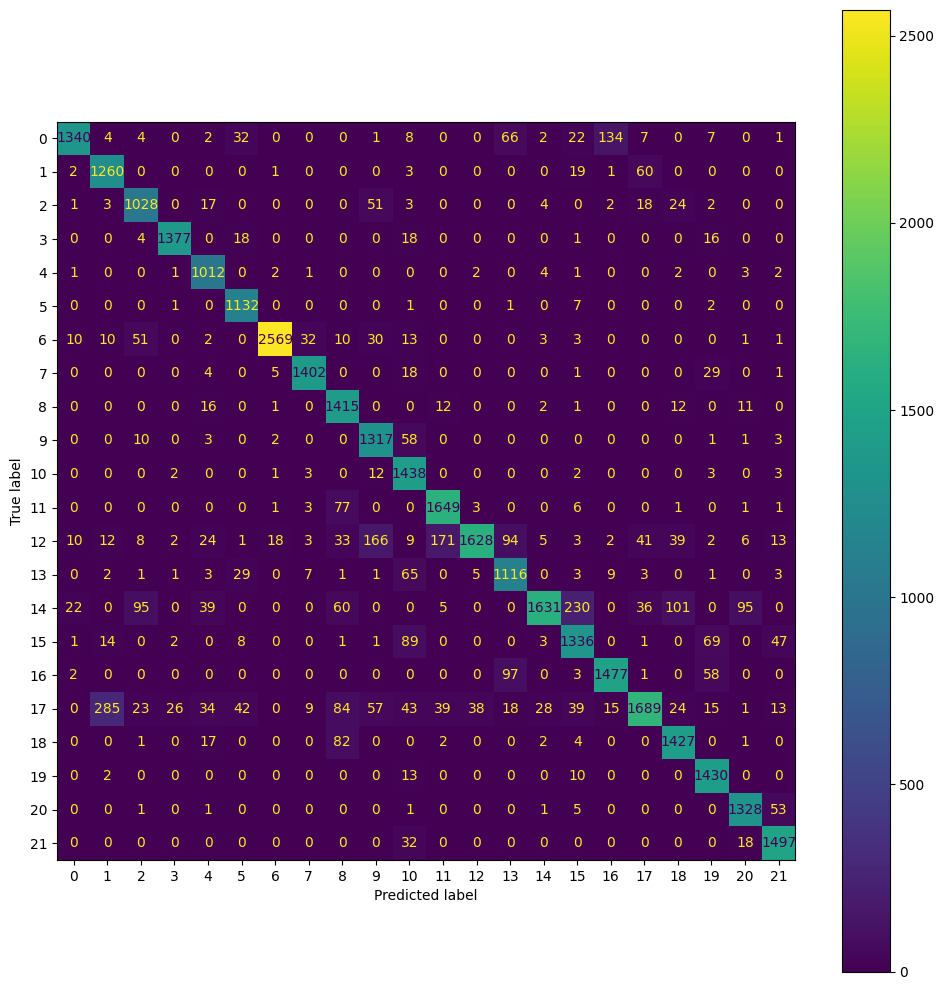

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["figure.autolayout"] = True
disp.plot()
plt.show()

In [ ]:
print(tl_model.classification_report)

              precision    recall  f1-score   support

           0       0.96      0.82      0.89      1630
           1       0.79      0.94      0.86      1346
           2       0.84      0.89      0.86      1153
           3       0.98      0.96      0.97      1434
           4       0.86      0.98      0.92      1031
           5       0.90      0.99      0.94      1144
           6       0.99      0.94      0.96      2735
           7       0.96      0.96      0.96      1460
           8       0.80      0.96      0.88      1470
           9       0.81      0.94      0.87      1395
          10       0.79      0.98      0.88      1464
          11       0.88      0.95      0.91      1742
          12       0.97      0.71      0.82      2290
          13       0.80      0.89      0.84      1250
          14       0.97      0.70      0.82      2314
          15       0.79      0.85      0.82      1572
          16       0.90      0.90      0.90      1638
          17       0.91    

# Original Model SubGraphs And Architecture

In [46]:


tf.lite.experimental.Analyzer.analyze(model_path=path, gpu_compatibility=True)

=== /content/keypoint_classifier_20241027010314_32000_undersampled.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the FULLY_CONNECTED op takes
tensor #0 and tensor #8 and tensor #1 as input and produces tensor #9 as output.

Subgraph#0 main(T#0) -> [T#13]
  Op#0 FULLY_CONNECTED(T#0, T#8, T#1) -> [T#9]
  Op#1 FULLY_CONNECTED(T#9, T#7, T#2) -> [T#10]
  Op#2 FULLY_CONNECTED(T#10, T#6, T#3) -> [T#11]
  Op#3 FULLY_CONNECTED(T#11, T#5, T#4) -> [T#12]
  Op#4 SOFTMAX(T#12) -> [T#13]

Tensors of Subgraph#0
  T#0(serving_default_input_layer:0) shape_signature:[-1, 63], type:FLOAT32
  T#1(arith.constant) shape:[1400], type:FLOAT32 RO 5600 bytes, buffer: 2, data:[0.0819035, 0.00570087, 0.0988243, 0.0589449, 0.00024651, ...]
  T#2(arith.constant1) shape:[200], type:FLOAT32 RO 800 bytes, buffer: 3, data:[0.0436594, -0.0732807, 0.0722659, 0.0220416, -0.0378029, ...]
  T#3(arith.constant2) shape:[60], 

**References:**


**Resize Interpretor Input Tensor:** https://www.comet.com/site/blog/running-tensorflow-lite-image-classification-models-in-python/

**Classification Report:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

  **Confusion Matrix:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
  
 **TFLite Model Analyzer :** https://ai.google.dev/edge/litert/models/model_analyzer
